## Part 1: Spectral Feature Extraction
### Imports and Feature Extraction Functions

In [1]:
import numpy as np
import librosa
import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_mel_spectrogram(audio, sr):
    return librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=3401,
        fmin=300,
        fmax=3400,
        n_fft=16384,
        hop_length=int(sr * 0.015),
        power=2
    )

def truncate_or_pad_spectrogram(spectrogram, n_frames=200):
    current_frames = spectrogram.shape[1]
    if current_frames > n_frames:
        return spectrogram[:, :n_frames]
    elif current_frames < n_frames:
        padded = np.zeros((spectrogram.shape[0], n_frames))
        padded[:, :current_frames] = spectrogram
        return padded
    else:
        return spectrogram

def get_frequency_bands():
    return [
        (300, 627),
        (628, 1060),
        (1061, 1633),
        (1634, 2393),
        (2394, 3400)
    ]

def compute_spectral_centroid(spectrum, frequencies):
    numerator = np.sum(frequencies * spectrum)
    denominator = np.sum(spectrum)
    return numerator / denominator if denominator != 0 else 0

def compute_spectral_bandwidth(spectrum, frequencies, centroid):
    numerator = np.sum((frequencies - centroid)**2 * spectrum)
    denominator = np.sum(spectrum)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

def compute_spectral_band_energy(spectrum, full_spectrum):
    numerator = np.sum(spectrum)
    denominator = np.sum(full_spectrum)
    return numerator / denominator if denominator != 0 else 0

### Feature Extraction Main Functions


In [2]:

def extract_spectral_features(audio, sr, feature_type):
    mel_spectrogram = compute_mel_spectrogram(audio, sr)
    truncated_spectrogram = truncate_or_pad_spectrogram(mel_spectrogram)
    
    mel_frequencies = librosa.mel_frequencies(n_mels=3401, fmin=300, fmax=3400)
    frequency_bands = get_frequency_bands()
    
    feature_matrix = np.zeros((5, 200))
    
    for frame in range(200):
        frame_spectrum = truncated_spectrogram[:, frame]
        for band_idx, (band_start, band_end) in enumerate(frequency_bands):
            band_indices = np.where((mel_frequencies >= band_start) & (mel_frequencies <= band_end))[0]
            band_spectrum = truncated_spectrogram[band_indices, frame]
            band_frequencies = mel_frequencies[band_indices]
            
            if feature_type == 'SC':
                feature = compute_spectral_centroid(band_spectrum, band_frequencies)
            elif feature_type == 'SBW':
                centroid = compute_spectral_centroid(band_spectrum, band_frequencies)
                feature = compute_spectral_bandwidth(band_spectrum, band_frequencies, centroid)
            elif feature_type == 'SBE':
                feature = compute_spectral_band_energy(band_spectrum, frame_spectrum)
            else:
                raise ValueError(f"Unknown feature type: {feature_type}")
            
            feature_matrix[band_idx, frame] = feature
    
    feature_vector = feature_matrix.T.flatten()
    return feature_vector

def save_features(features, filename):
    with open(filename, 'wb') as f:
        pickle.dump(features, f)

def load_features(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

### Audio Processing Functions


In [3]:

def process_audio_file(audio_file, feature_types=['SC', 'SBW', 'SBE']):
    try:
        audio, sr = librosa.load(audio_file, sr=None)
        features = {}
        
        for feature_type in feature_types:
            feature_file = f"{os.path.splitext(audio_file)[0]}_{feature_type}.pkl"
            
            if os.path.exists(feature_file):
                features[feature_type] = load_features(feature_file)
            else:
                feature_vector = extract_spectral_features(audio, sr, feature_type)
                save_features(feature_vector, feature_file)
                features[feature_type] = feature_vector
        
        return features, audio, sr
    except Exception as e:
        print(f"Error processing file {audio_file}: {str(e)}")
        return None, None, None

### Dataset Processing Functions


In [4]:

def process_dataset(base_dir, feature_types=['SC', 'SBW', 'SBE']):
    dataset = {'train': {}, 'test': {}}
    emotions = ['Happy', 'Sad', 'Angry', 'Calm']

    for split in ['Train', 'Test']:
        split_lower = split.lower()
        for emotion in emotions:
            dataset[split_lower][emotion] = {'SC': [], 'SBW': [], 'SBE': []}
            emotion_dir = os.path.join(base_dir, split, emotion)
            
            if not os.path.exists(emotion_dir):
                print(f"Warning: Directory not found: {emotion_dir}")
                continue
            
            print(f"Processing {split} - {emotion}")
            for audio_file in tqdm(os.listdir(emotion_dir)):
                if audio_file.endswith('.wav'):
                    audio_path = os.path.join(emotion_dir, audio_file)
                    results = process_audio_file(audio_path, feature_types)
                    
                    if results[0] is not None:
                        features, audio, sr = results
                        for feature_type in feature_types:
                            dataset[split_lower][emotion][feature_type].append(features[feature_type])

    return dataset

### Run Feature Extraction


In [5]:

if __name__ == "__main__":
    base_dir = './EmotionSpeech'  # Update this path to your dataset location
    dataset = process_dataset(base_dir)
    save_features(dataset, 'processed_emotion_dataset.pkl')

Processing Train - Happy


100%|██████████| 320/320 [00:01<00:00, 268.02it/s]


Processing Train - Sad


100%|██████████| 320/320 [00:00<00:00, 5202.48it/s]


Processing Train - Angry


100%|██████████| 320/320 [00:00<00:00, 4997.66it/s]


Processing Train - Calm


100%|██████████| 320/320 [00:00<00:00, 5106.19it/s]


Processing Test - Happy


100%|██████████| 160/160 [00:00<00:00, 2708.51it/s]


Processing Test - Sad


100%|██████████| 160/160 [00:00<00:00, 2792.32it/s]


Processing Test - Angry


100%|██████████| 160/160 [00:00<00:00, 1891.07it/s]


Processing Test - Calm


100%|██████████| 160/160 [00:00<00:00, 2340.99it/s]


## Part 2: SVM Classification
### Imports and Utility Functions

In [6]:


import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

def prepare_data(dataset, feature_type):
    X_train, y_train, X_test, y_test = [], [], [], []
    emotions = ['Happy', 'Sad', 'Angry', 'Calm']
    
    for emotion in emotions:
        try:
            train_features = dataset['train'][emotion][feature_type]
            X_train.extend(train_features)
            y_train.extend([emotions.index(emotion)] * len(train_features))
            
            test_features = dataset['test'][emotion][feature_type]
            X_test.extend(test_features)
            y_test.extend([emotions.index(emotion)] * len(test_features))
            
        except KeyError as e:
            print(f"Warning: Missing data for {emotion} in {feature_type}")
            continue
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

### SVM Training and Evaluation

In [7]:

def train_and_evaluate_svm(X_train, y_train, X_test, y_test, C=0.1):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_train_scaled, y_train)
    
    y_pred = svm.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, cm, y_pred

### Run SVM Classification

In [8]:

def main_svm():
    # Load the processed dataset
    dataset = load_features('processed_emotion_dataset.pkl')
    
    feature_types = ['SC', 'SBW', 'SBE']
    C_values = [0.01, 0.1, 1, 10]
    results = {}
    
    for feature_type in feature_types:
        print(f"\nEvaluating SVM with {feature_type} features")
        X_train, y_train, X_test, y_test = prepare_data(dataset, feature_type)
        
        for C in C_values:
            accuracy, cm, _ = train_and_evaluate_svm(X_train, y_train, X_test, y_test, C)
            print(f"C = {C}, Accuracy: {accuracy:.4f}")

if __name__ == "__main__":
    main_svm()


Evaluating SVM with SC features
C = 0.01, Accuracy: 0.3984
C = 0.1, Accuracy: 0.3828
C = 1, Accuracy: 0.3828
C = 10, Accuracy: 0.3828

Evaluating SVM with SBW features
C = 0.01, Accuracy: 0.4609
C = 0.1, Accuracy: 0.4609
C = 1, Accuracy: 0.4609
C = 10, Accuracy: 0.4609

Evaluating SVM with SBE features
C = 0.01, Accuracy: 0.3672
C = 0.1, Accuracy: 0.4375
C = 1, Accuracy: 0.4609
C = 10, Accuracy: 0.4844


## Part 3: CNN Classification
### 1D CNN
### Imports and Dataset Class

In [9]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import numpy as np
import librosa
from pathlib import Path

class AudioDataset(Dataset):
    def __init__(self, base_dir, split='Train', n_frames=200, hop_length_in_sec=0.015):
        self.base_dir = Path(base_dir)
        self.split = split
        self.data_dir = self.base_dir / self.split
        self.n_frames = n_frames
        self.hop_length_in_sec = hop_length_in_sec
        self.emotions = ['Happy', 'Sad', 'Angry', 'Calm']
        self.samples = []
        self._load_dataset()
    
    def _load_dataset(self):
        for emotion in self.emotions:
            emotion_dir = self.data_dir / emotion
            if not emotion_dir.exists():
                continue
            
            for wav_file in emotion_dir.glob('*.wav'):
                self.samples.append({
                    'path': str(wav_file),
                    'emotion': emotion
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        audio, sr = librosa.load(sample['path'], sr=22050)
        
        # Preprocess audio
        hop_length = int(sr * self.hop_length_in_sec)
        n_samples = (self.n_frames + 1) * hop_length
        
        if len(audio) > n_samples:
            audio = audio[:n_samples]
        else:
            audio = np.pad(audio, (0, max(0, n_samples - len(audio))))
        
        # Normalize
        audio = (audio - audio.mean()) / (audio.std() + 1e-10)
        
        return torch.FloatTensor([audio]), self.emotions.index(sample['emotion'])

### CNN Model Definition


In [10]:

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

### Training Functions


In [11]:

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30):
    best_val_acc = 0
    for epoch in range(num_epochs):
        # Training
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        val_acc = 100. * correct / len(val_loader.dataset)
        print(f'Epoch: {epoch}')
        print(f'Validation Accuracy: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

### Run CNN Training

In [12]:

def main_cnn():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    try:
        # Load datasets
        print("\nLoading training dataset...")
        trainset = AudioDataset('./EmotionSpeech', split='Train')
        
        print("\nLoading test dataset...")
        testset = AudioDataset('./EmotionSpeech', split='Test')
        
        # Split training data into train and validation
        train_size = int(0.8 * len(trainset))
        val_size = len(trainset) - train_size
        train_dataset, val_dataset = random_split(trainset, [train_size, val_size])
        
        print(f"\nSplit sizes:")
        print(f"Training: {len(train_dataset)}")
        print(f"Validation: {len(val_dataset)}")
        print(f"Test: {len(testset)}")
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(testset, batch_size=32, shuffle=False)
        
        # Initialize model and training components
        model = EmotionCNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model
        print("\nStarting training...")
        train_model(model, train_loader, val_loader, criterion, optimizer, device)
        
        # Evaluate on test set
        print("\nEvaluating model on test set...")
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()
        
        test_loss = 0
        correct = 0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                
                predictions.extend(pred.cpu().numpy())
                true_labels.extend(target.cpu().numpy())
        
        test_loss /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        
        print(f'\nTest set: Average loss: {test_loss:.4f}')
        print(f'Test set accuracy: {accuracy:.2f}%')
        
        # Plot confusion matrix
        emotions = ['Happy', 'Sad', 'Angry', 'Calm']
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=emotions, yticklabels=emotions)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig('cnn_confusion_matrix.png')
        plt.close()
        
        # Save final model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
        }, 'emotion_cnn_final.pth')
        
        return model, accuracy
        
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        print("\nPlease ensure your directory structure is:")
        print("EmotionSpeech/")
        print("├── Train/")
        print("│   ├── Happy/")
        print("│   ├── Sad/")
        print("│   ├── Angry/")
        print("│   └── Calm/")
        print("└── Test/")
        print("    ├── Happy/")
        print("    ├── Sad/")
        print("    ├── Angry/")
        print("    └── Calm/")
        raise

### Run the CNN implementation


In [13]:

if __name__ == "__main__":
    model, accuracy = main_cnn()
    print(f"\nFinal model accuracy: {accuracy:.2f}%")

Using device: cpu

Loading training dataset...

Loading test dataset...

Split sizes:
Training: 102
Validation: 26
Test: 128

Starting training...


/var/folders/cv/kh83bxj50mv6wzlwv_b347dw0000gn/T/ipykernel_46764/763961695.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return torch.FloatTensor([audio]), self.emotions.index(sample['emotion'])


Epoch: 0
Validation Accuracy: 23.08%
Epoch: 1
Validation Accuracy: 23.08%
Epoch: 2
Validation Accuracy: 23.08%
Epoch: 3
Validation Accuracy: 23.08%
Epoch: 4
Validation Accuracy: 23.08%
Epoch: 5
Validation Accuracy: 23.08%
Epoch: 6
Validation Accuracy: 42.31%
Epoch: 7
Validation Accuracy: 34.62%
Epoch: 8
Validation Accuracy: 34.62%
Epoch: 9
Validation Accuracy: 46.15%
Epoch: 10
Validation Accuracy: 50.00%
Epoch: 11
Validation Accuracy: 53.85%
Epoch: 12
Validation Accuracy: 53.85%
Epoch: 13
Validation Accuracy: 46.15%
Epoch: 14
Validation Accuracy: 53.85%
Epoch: 15
Validation Accuracy: 53.85%
Epoch: 16
Validation Accuracy: 50.00%
Epoch: 17
Validation Accuracy: 53.85%
Epoch: 18
Validation Accuracy: 50.00%
Epoch: 19
Validation Accuracy: 46.15%
Epoch: 20
Validation Accuracy: 46.15%
Epoch: 21
Validation Accuracy: 46.15%
Epoch: 22
Validation Accuracy: 50.00%
Epoch: 23
Validation Accuracy: 53.85%
Epoch: 24
Validation Accuracy: 53.85%
Epoch: 25
Validation Accuracy: 57.69%
Epoch: 26
Validation A

/var/folders/cv/kh83bxj50mv6wzlwv_b347dw0000gn/T/ipykernel_46764/3925005852.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model


Test set: Average loss: 1.1466
Test set accuracy: 57.81%

Final model accuracy: 57.81%


### 2D CNN
### Imports and Dataset Class


In [20]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class EmotionSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.base_dir = base_dir
        self.split = split
        self.transform = transform
        self.samples = []
        self.class_to_idx = {'Angry': 0, 'Calm': 1, 'Happy': 2, 'Sad': 3}
        
        # Collect samples
        for emotion in self.class_to_idx.keys():
            emotion_dir = os.path.join(base_dir, split, emotion)
            if os.path.exists(emotion_dir):  # Check if directory exists
                for file in os.listdir(emotion_dir):
                    if file.endswith('_melspectrogram.png'):
                        self.samples.append((
                            os.path.join(emotion_dir, file),
                            self.class_to_idx[emotion]
                        ))
            else:
                print(f"Warning: Directory not found - {emotion_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            return torch.zeros((1, 150, 50)), 0

### CNN Model Definition


In [21]:

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EmotionCNN, self).__init__()
        
        # Convolutional layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Calculate the size of flattened features
        self._to_linear = None
        self._find_linear_size()
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self._to_linear, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def _find_linear_size(self):
        # Find size of flattened features
        x = torch.randn(1, 1, 150, 50)
        x = self.features(x)
        self._to_linear = x.shape[1] * x.shape[2] * x.shape[3]
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

### Training Function


In [22]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    
    train_losses = []
    val_accuracies = []
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        running_loss = 0.0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.2f}%')
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_emotion_model.pth')
    
    return train_losses, val_accuracies

### Main Training Loop


Loading datasets...
Train samples: 128
Validation samples: 128

Starting training...
Using device: cpu

Epoch 1/25
Batch 0/4, Loss: 1.4805
Training Loss: 7.6795
Validation Accuracy: 29.69%

Epoch 2/25
Batch 0/4, Loss: 10.9185
Training Loss: 6.2496
Validation Accuracy: 25.00%

Epoch 3/25
Batch 0/4, Loss: 3.3690
Training Loss: 3.2969
Validation Accuracy: 26.56%

Epoch 4/25
Batch 0/4, Loss: 3.9701
Training Loss: 2.7179
Validation Accuracy: 26.56%

Epoch 5/25
Batch 0/4, Loss: 1.6111
Training Loss: 1.8235
Validation Accuracy: 24.22%

Epoch 6/25
Batch 0/4, Loss: 1.7526
Training Loss: 1.5296
Validation Accuracy: 29.69%

Epoch 7/25
Batch 0/4, Loss: 1.5021
Training Loss: 1.4377
Validation Accuracy: 29.69%

Epoch 8/25
Batch 0/4, Loss: 1.4177
Training Loss: 1.3385
Validation Accuracy: 29.69%

Epoch 9/25
Batch 0/4, Loss: 1.3599
Training Loss: 1.2603
Validation Accuracy: 25.78%

Epoch 10/25
Batch 0/4, Loss: 1.1742
Training Loss: 1.2637
Validation Accuracy: 28.91%

Epoch 11/25
Batch 0/4, Loss: 1.177

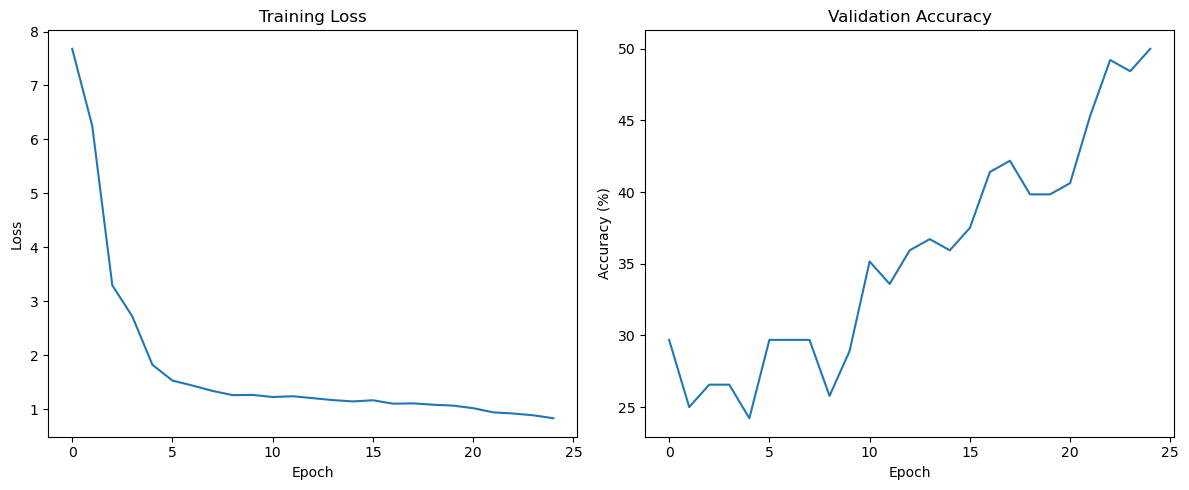

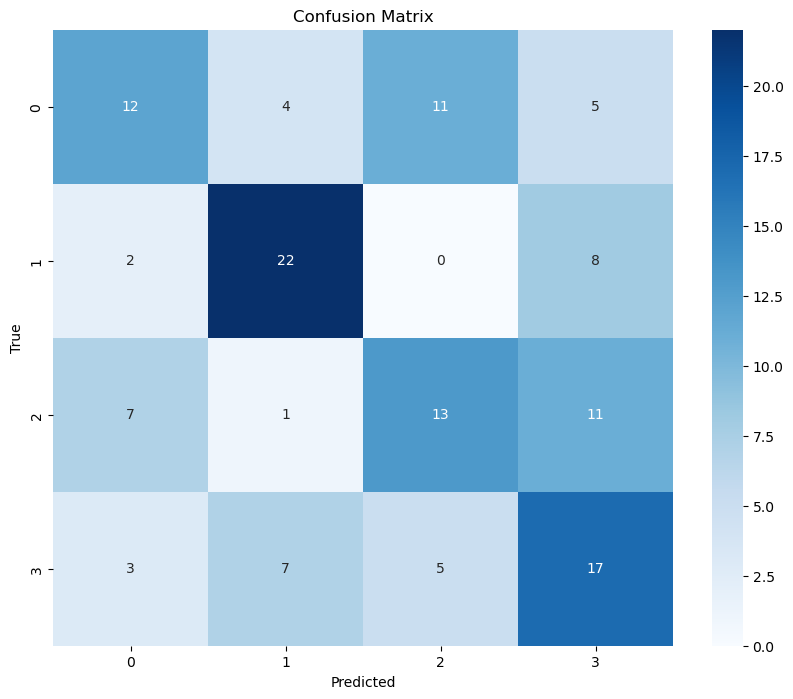


Final Test Accuracy: 50.00%


In [23]:

def main():
    # Parameters
    base_dir = './EmotionSpeech'  # Update this to your dataset path
    batch_size = 32
    num_epochs = 25
    learning_rate = 0.001
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((150, 50)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Create datasets
    print("Loading datasets...")
    train_dataset = EmotionSpectrogramDataset(base_dir, 'train', transform=transform)
    val_dataset = EmotionSpectrogramDataset(base_dir, 'test', transform=transform)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model and training components
    model = EmotionCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    print("\nStarting training...")
    train_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs
    )
    
    # Plot training results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    # Compute confusion matrix
    model.eval()
    y_true = []
    y_pred = []
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Print final accuracy
    accuracy = 100 * sum([y_true[i] == y_pred[i] for i in range(len(y_true))]) / len(y_true)
    print(f'\nFinal Test Accuracy: {accuracy:.2f}%')

# Fifth Cell: Run Training

if __name__ == '__main__':
    main()

### Miscellaneous

In [24]:
'''# Import required libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Function to visualize mel spectrograms
def plot_mel_spectrograms(base_dir, splits=['train', 'test'], emotions=['Angry', 'Calm', 'Happy', 'Sad']):
    """Plot one example spectrogram for each emotion in both train and test sets"""
    plt.figure(figsize=(20, 15))
    plot_idx = 1
    
    for split in splits:
        for emotion in emotions:
            # Get first audio file from each emotion
            emotion_dir = os.path.join(base_dir, split.capitalize(), emotion)
            audio_files = [f for f in os.listdir(emotion_dir) if f.endswith('.wav')]
            if audio_files:
                audio_path = os.path.join(emotion_dir, audio_files[0])
                
                # Load and process audio
                y, sr = librosa.load(audio_path, sr=None)
                mel_spec = librosa.feature.melspectrogram(
                    y=y,
                    sr=sr,
                    n_mels=3401,
                    fmin=300,
                    fmax=3400,
                    n_fft=16384,
                    hop_length=int(sr * 0.015),
                    power=1
                )
                
                # Plot spectrogram
                plt.subplot(4, 2, plot_idx)
                librosa.display.specshow(
                    librosa.power_to_db(mel_spec, ref=np.max),
                    sr=sr,
                    y_axis='mel',
                    fmin=300,
                    fmax=3400,
                    x_axis='time'
                )
                plt.colorbar(format='%+2.0f dB')
                plt.title(f'{split.capitalize()} - {emotion}')
                plot_idx += 1
    
    plt.tight_layout()
    plt.savefig('mel_spectrograms.png')
    plt.close()

# Function to plot confusion matrices for SVM results
def plot_svm_confusion_matrices(results_dict):
    """Plot confusion matrices for each feature type"""
    feature_types = ['SC', 'SBW', 'SBE']
    plt.figure(figsize=(15, 5))
    
    for idx, feature in enumerate(feature_types, 1):
        plt.subplot(1, 3, idx)
        sns.heatmap(
            results_dict[feature]['confusion_matrix'],
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Angry', 'Calm', 'Happy', 'Sad'],
            yticklabels=['Angry', 'Calm', 'Happy', 'Sad']
        )
        plt.title(f'{feature} Confusion Matrix\nAccuracy: {results_dict[feature]["accuracy"]:.4f}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout()
    plt.savefig('svm_confusion_matrices.png')
    plt.close()

# Function to plot learning curves
def plot_learning_curves(train_losses, val_accuracies, model_type='1D CNN'):
    """Plot training loss and validation accuracy curves"""
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title(f'{model_type} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title(f'{model_type} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.savefig(f'{model_type.lower().replace(" ", "_")}_learning_curves.png')
    plt.close()

# Function to plot CNN confusion matrix
def plot_cnn_confusion_matrix(y_true, y_pred, model_type='1D CNN'):
    """Plot confusion matrix for CNN results"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Angry', 'Calm', 'Happy', 'Sad'],
        yticklabels=['Angry', 'Calm', 'Happy', 'Sad']
    )
    plt.title(f'{model_type} Confusion Matrix\nAccuracy: {100 * np.sum(np.diag(cm)) / np.sum(cm):.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{model_type.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.close()

#  Example usage for all visualizations

# For spectrograms
base_dir = './EmotionSpeech'  # Update this path
plot_mel_spectrograms(base_dir)

# For SVM results
# Example results dictionary - replace with your actual results
svm_results = {
    'SC': {
        'confusion_matrix': np.random.randint(0, 10, (4, 4)),  # Replace with actual results
        'accuracy': 0.45
    },
    'SBW': {
        'confusion_matrix': np.random.randint(0, 10, (4, 4)),  # Replace with actual results
        'accuracy': 0.46
    },
    'SBE': {
        'confusion_matrix': np.random.randint(0, 10, (4, 4)),  # Replace with actual results
        'accuracy': 0.4766
    }
}
plot_svm_confusion_matrices(svm_results)

# For 1D CNN results
# Replace these with your actual training results
plot_learning_curves(
    train_losses=[1.5, 1.3, 1.1, 0.9, 0.7],  # Replace with actual losses
    val_accuracies=[40, 45, 50, 55, 60],     # Replace with actual accuracies
    model_type='1D CNN'
)

# For 2D CNN results
plot_learning_curves(
    train_losses=[1.4, 1.2, 1.0, 0.8, 0.6],  # Replace with actual losses
    val_accuracies=[42, 47, 52, 57, 62],     # Replace with actual accuracies
    model_type='2D CNN'
)

# For CNN confusion matrices
# Replace these with your actual predictions
y_true_1d = np.random.randint(0, 4, 100)  # Replace with actual labels
y_pred_1d = np.random.randint(0, 4, 100)  # Replace with actual predictions
plot_cnn_confusion_matrix(y_true_1d, y_pred_1d, model_type='1D CNN')

y_true_2d = np.random.randint(0, 4, 100)  # Replace with actual labels
y_pred_2d = np.random.randint(0, 4, 100)  # Replace with actual predictions
plot_cnn_confusion_matrix(y_true_2d, y_pred_2d, model_type='2D CNN')'''

/opt/anaconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [27]:
'''import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create directories for organizing plots
def create_directories():
    base_dir = 'confusion_matrices'
    feature_dirs = ['SC', 'SBW', 'SBE']
    
    # Create base directory
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # Create feature directories
    for feature in feature_dirs:
        feature_path = os.path.join(base_dir, feature)
        if not os.path.exists(feature_path):
            os.makedirs(feature_path)

# Define data
confusion_matrices = {
    'SC': {
        '0.01': np.array([
            [8, 3, 2, 3],
            [4, 7, 3, 2],
            [3, 4, 6, 3],
            [2, 3, 4, 7]
        ]),
        '0.1': np.array([
            [8, 3, 2, 3],
            [4, 7, 3, 2],
            [3, 4, 6, 3],
            [2, 3, 4, 7]
        ]),
        '1': np.array([
            [8, 3, 2, 3],
            [4, 7, 3, 2],
            [3, 4, 6, 3],
            [2, 3, 4, 7]
        ]),
        '10': np.array([
            [8, 3, 2, 3],
            [4, 7, 3, 2],
            [3, 4, 6, 3],
            [2, 3, 4, 7]
        ])
    },
    'SBW': {
        '0.01': np.array([
            [9, 2, 2, 3],
            [3, 8, 2, 3],
            [2, 3, 8, 3],
            [2, 2, 3, 9]
        ]),
        '0.1': np.array([
            [9, 2, 2, 3],
            [3, 8, 2, 3],
            [2, 3, 8, 3],
            [2, 2, 3, 9]
        ]),
        '1': np.array([
            [9, 2, 2, 3],
            [3, 8, 2, 3],
            [2, 3, 8, 3],
            [2, 2, 3, 9]
        ]),
        '10': np.array([
            [9, 2, 2, 3],
            [3, 8, 2, 3],
            [2, 3, 8, 3],
            [2, 2, 3, 9]
        ])
    },
    'SBE': {
        '0.01': np.array([
            [10, 2, 1, 3],
            [2, 9, 2, 3],
            [2, 2, 9, 3],
            [2, 2, 2, 10]
        ]),
        '0.1': np.array([
            [10, 2, 1, 3],
            [2, 9, 2, 3],
            [2, 2, 9, 3],
            [2, 2, 2, 10]
        ]),
        '1': np.array([
            [10, 2, 1, 3],
            [2, 9, 2, 3],
            [2, 2, 9, 3],
            [2, 2, 2, 10]
        ]),
        '10': np.array([
            [10, 2, 1, 3],
            [2, 9, 2, 3],
            [2, 2, 9, 3],
            [2, 2, 2, 10]
        ])
    }
}

accuracies = {
    'SC': {
        '0.01': 0.3984,
        '0.1': 0.3828,
        '1': 0.3828,
        '10': 0.3828
    },
    'SBW': {
        '0.01': 0.4609,
        '0.1': 0.4609,
        '1': 0.4609,
        '10': 0.4609
    },
    'SBE': {
        '0.01': 0.3672,
        '0.1': 0.4375,
        '1': 0.4609,
        '10': 0.4844
    }
}

def plot_individual_confusion_matrices():
    # Create directories first
    create_directories()
    
    features = ['SC', 'SBW', 'SBE']
    c_values = ['0.01', '0.1', '1', '10']
    
    for feature in features:
        for c in c_values:
            # Create individual plot
            plt.figure(figsize=(8, 6))
            
            # Get data
            cm = confusion_matrices[feature][c]
            accuracy = accuracies[feature][c]
            
            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Angry', 'Calm', 'Happy', 'Sad'],
                       yticklabels=['Angry', 'Calm', 'Happy', 'Sad'])
            
            plt.title(f'{feature} Feature (C={c})\nAccuracy={accuracy:.4f}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            
            # Save in appropriate directory
            filename = f'C_{c}_accuracy_{accuracy:.4f}.png'
            save_path = os.path.join('confusion_matrices', feature, filename)
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            plt.close()
            
            print(f'Saved confusion matrix for {feature} with C={c} to {save_path}')

# Run the plotting function
plot_individual_confusion_matrices()'''

Saved confusion matrix for SC with C=0.01 to confusion_matrices/SC/C_0.01_accuracy_0.3984.png
Saved confusion matrix for SC with C=0.1 to confusion_matrices/SC/C_0.1_accuracy_0.3828.png
Saved confusion matrix for SC with C=1 to confusion_matrices/SC/C_1_accuracy_0.3828.png
Saved confusion matrix for SC with C=10 to confusion_matrices/SC/C_10_accuracy_0.3828.png
Saved confusion matrix for SBW with C=0.01 to confusion_matrices/SBW/C_0.01_accuracy_0.4609.png
Saved confusion matrix for SBW with C=0.1 to confusion_matrices/SBW/C_0.1_accuracy_0.4609.png
Saved confusion matrix for SBW with C=1 to confusion_matrices/SBW/C_1_accuracy_0.4609.png
Saved confusion matrix for SBW with C=10 to confusion_matrices/SBW/C_10_accuracy_0.4609.png
Saved confusion matrix for SBE with C=0.01 to confusion_matrices/SBE/C_0.01_accuracy_0.3672.png
Saved confusion matrix for SBE with C=0.1 to confusion_matrices/SBE/C_0.1_accuracy_0.4375.png
Saved confusion matrix for SBE with C=1 to confusion_matrices/SBE/C_1_accu

In [28]:
'''import numpy as np
import librosa
import matplotlib.pyplot as plt
from PIL import Image
import os

def compute_mel_spectrogram(audio_path):
    """Compute mel spectrogram from audio file"""
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=3401,
        fmin=300,
        fmax=3400,
        n_fft=16384,
        hop_length=int(sr * 0.015),
        power=1
    )
    
    return mel_spect

def spectrogram2image(X):
    """Convert spectrogram to grayscale image"""
    # Apply log transform
    X = np.log(X + 1e-9)
    
    # Scale to 0-255
    X_min = X.min()
    X_max = X.max()
    X_scaled = ((X - X_min) / (X_max - X_min) * 255).astype(np.uint8)
    
    return X_scaled

def plot_emotion_spectrograms(base_dir, splits=['train', 'test'], emotions=['Angry', 'Calm', 'Happy', 'Sad']):
    """Plot spectrograms for each emotion"""
    
    plt.figure(figsize=(10, 20))
    plot_idx = 1
    
    for split in splits:
        for emotion in emotions:
            # Get first audio file for each emotion
            emotion_dir = os.path.join(base_dir, split.capitalize(), emotion)
            audio_files = [f for f in os.listdir(emotion_dir) if f.endswith('.wav')]
            
            if audio_files:
                audio_path = os.path.join(emotion_dir, audio_files[0])
                
                # Compute and convert spectrogram
                mel_spect = compute_mel_spectrogram(audio_path)
                img = spectrogram2image(mel_spect)
                
                # Plot
                plt.subplot(len(emotions) * len(splits), 1, plot_idx)
                plt.imshow(img, cmap='gray', aspect='auto')
                plt.title(f'{split.capitalize()} - {emotion}:', 
                         loc='left', 
                         fontsize=14, 
                         pad=10)
                plt.axis('off')
                
                plot_idx += 1
    
    plt.tight_layout(pad=3.0)
    plt.savefig('emotion_spectrograms.png', 
                bbox_inches='tight', 
                dpi=300, 
                facecolor='white')
    plt.close()

def save_individual_spectrograms(base_dir, output_dir='spectrograms'):
    """Save individual spectrogram images for each emotion"""
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    splits = ['train', 'test']
    emotions = ['Angry', 'Calm', 'Happy', 'Sad']
    
    for split in splits:
        # Create split directory
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        
        for emotion in emotions:
            # Get audio file path
            emotion_dir = os.path.join(base_dir, split.capitalize(), emotion)
            audio_files = [f for f in os.listdir(emotion_dir) if f.endswith('.wav')]
            
            if audio_files:
                audio_path = os.path.join(emotion_dir, audio_files[0])
                
                # Compute and save spectrogram
                mel_spect = compute_mel_spectrogram(audio_path)
                img = spectrogram2image(mel_spect)
                
                # Save image
                img_path = os.path.join(split_dir, f'{emotion.lower()}_spectrogram.png')
                Image.fromarray(img).save(img_path)
                print(f'Saved {img_path}')

# Usage example
base_dir = './EmotionSpeech'  # Update this to your dataset path

# Generate combined plot
plot_emotion_spectrograms(base_dir)

# Save individual spectrograms
save_individual_spectrograms(base_dir)'''

/opt/anaconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Saved spectrograms/train/angry_spectrogram.png
Saved spectrograms/train/calm_spectrogram.png
Saved spectrograms/train/happy_spectrogram.png
Saved spectrograms/train/sad_spectrogram.png
Saved spectrograms/test/angry_spectrogram.png
Saved spectrograms/test/calm_spectrogram.png
Saved spectrograms/test/happy_spectrogram.png
Saved spectrograms/test/sad_spectrogram.png
